In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew  
%matplotlib inline

In [174]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

In [175]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [176]:
train.isnull().sum().head()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage    259
LotArea          0
dtype: int64

In [177]:
test.isnull().sum().head()

Id               0
MSSubClass       0
MSZoning         4
LotFrontage    227
LotArea          0
dtype: int64

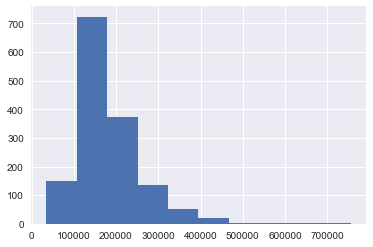

In [178]:
# data is right skewed
train['SalePrice'].hist()

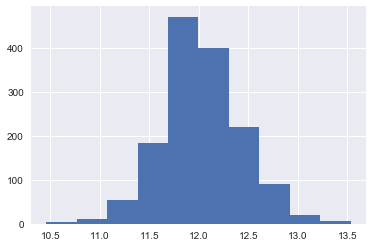

In [179]:
# After log the deviation seems to be normal 
np.log1p(train['SalePrice']).hist()

In [180]:
# get numeric and non numeric cols
numeric_cols = [ col for col in train.columns if train[col].dtype!="object" ]
categorical_cols = [col for col in train.columns if col not in numeric_cols]

In [181]:
bothdf = pd.concat([train,test],axis=0)

In [182]:
empty_df =  pd.DataFrame(bothdf.isnull().sum(),columns=['Empty Values'])
empty_df[empty_df['Empty Values']>1000]

,Empty Values
Alley,2721
Fence,2348
FireplaceQu,1420
MiscFeature,2814
PoolQC,2909
SalePrice,1459


In [183]:
bothdf = bothdf.drop(['Alley','Fence','FireplaceQu','MiscFeature','PoolQC'],axis=1)
empty_df = empty_df.drop(['Alley','Fence','FireplaceQu','MiscFeature','PoolQC'],axis=0)


In [184]:
empty_df = empty_df[empty_df['Empty Values']>0]
empty_df = empty_df.sort_values(ascending=False,by='Empty Values')
empty_df.head()

,Empty Values
SalePrice,1459
LotFrontage,486
GarageYrBlt,159
GarageQual,159
GarageFinish,159


In [185]:
# get the highest correlation wrt LotFrontage
# seems like LotFrontage has high corr wrt LotArea,1stFlrSF,GrLivArea,GarageArea
corrdf = pd.DataFrame(bothdf.corr())
corrdf['LotFrontage'].sort_values(ascending=False).head()

LotFrontage    1.000000
LotArea        0.489896
1stFlrSF       0.458247
GrLivArea      0.382462
GarageArea     0.359786
Name: LotFrontage, dtype: float64

In [186]:
# preparing internal ML model to get lotfrontage missing values
bothdf[bothdf['LotFrontage'].notnull()].head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,3,1Fam,TA,No,706.0,0.0,GLQ,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,3,1Fam,TA,Gd,978.0,0.0,ALQ,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,3,1Fam,TA,Mn,486.0,0.0,GLQ,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,3,1Fam,Gd,No,216.0,0.0,ALQ,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,4,1Fam,TA,Av,655.0,0.0,GLQ,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [187]:
# preparing the dataframe for processing
lotFr = bothdf[['LotArea','1stFlrSF','GrLivArea','GarageArea','LotFrontage']]
lotFr_nn = lotFr[lotFr['LotFrontage'].notnull() & lotFr['GarageArea'].notnull()]
lotFr.count()
lotFr_nn.isnull().sum()

LotArea        0
1stFlrSF       0
GrLivArea      0
GarageArea     0
LotFrontage    0
dtype: int64

In [193]:
X_lot = lotFr_nn.iloc[:, :-1].values
y_lot = lotFr_nn.iloc[:, :4].values

In [194]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_lot, y_lot, test_size = 0.2, random_state = 0)

In [195]:
from sklearn.preprocessing import StandardScaler
sc_lotfr_X = StandardScaler()
sc_lotfr_Y = StandardScaler()

X_lot_train = sc_lotfr_X.fit_transform(X_train)
X_lot_test = sc_lotfr_X.transform(X_test)

y_lot_train = sc_lotfr_Y.fit_transform(y_train)
y_lot_test = sc_lotfr_Y.transform(y_test)
y_lot_test

array([[ 1.68003075, -0.20157271,  0.15567425,  0.26288401],
       [-0.18552924, -0.2798153 , -0.8838625 , -0.31187824],
       [ 0.29960353,  0.8547022 ,  0.01603498,  0.0383675 ],
       ..., 
       [ 0.2334953 ,  1.17256271,  0.26816143,  1.78061558],
       [ 0.50548348,  0.5612925 , -0.21669713,  1.91532548],
       [ 0.25310983,  0.93538987,  0.08003631,  1.43036983]])